<a href="https://colab.research.google.com/github/Nimisha-Nooti/Healthcare-Analytics-Practicum/blob/main/Final_cleaned_dataset_of_SVI%2C_SPARCS_Fatalities_hospitals%26beds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏥 SPARCS + ACS + COVID + SVI County-Level Analysis

This notebook processes SPARCS inpatient discharges from a local CSV and merges it with:
- ACS SDOH (via Census API)
- COVID data (via NY Open Data)
- CDC SVI (via GitHub)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [27]:
import pandas as pd
import numpy as np
import requests
sparcs_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Merged_SPARCS_2020_2022.csv', low_memory=False)



In [28]:
# 🔑 Census API key
CENSUS_API_KEY = "db85a2b89f20a2f475e39e8857307daad851ef6a"

## 📥 Load SPARCS CSV

In [29]:
# Load SPARCS CSV (must be in same folder)
sparcs_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Merged_SPARCS_2020_2022.csv", low_memory=False)
print("SPARCS columns:", sparcs_df.columns.tolist())

# Select relevant fields
selected_cols = [
    'Hospital County', 'Hospital Service Area', 'Discharge Year',
    'Age Group', 'Gender', 'Race', 'Ethnicity',
    'Type of Admission', 'Patient Disposition',
    'Length of Stay', 'Total Charges', 'Total Costs',
    'APR DRG Description', 'APR Severity of Illness Description', 'APR Risk of Mortality',
    'Payment Typology 1', 'Payment Typology 2'
]
sparcs_filtered = sparcs_df[selected_cols].copy()
sparcs_filtered['Length of Stay'] = pd.to_numeric(sparcs_filtered['Length of Stay'], errors='coerce')
sparcs_filtered['Total Charges'] = pd.to_numeric(sparcs_filtered['Total Charges'], errors='coerce')
sparcs_filtered['Total Costs'] = pd.to_numeric(sparcs_filtered['Total Costs'], errors='coerce')
sparcs_filtered.dropna(subset=['Hospital County'], inplace=True)
sparcs_filtered['Hospital County'] = sparcs_filtered['Hospital County'].str.title()

SPARCS columns: ['Hospital Service Area', 'Hospital County', 'Operating Certificate Number', 'Permanent Facility Id', 'Facility Name', 'Age Group', 'Zip Code - 3 digits', 'Gender', 'Race', 'Ethnicity', 'Length of Stay', 'Type of Admission', 'Patient Disposition', 'Discharge Year', 'CCSR Diagnosis Code', 'CCSR Diagnosis Description', 'CCSR Procedure Code', 'CCSR Procedure Description', 'APR DRG Code', 'APR DRG Description', 'APR MDC Code', 'APR MDC Description', 'APR Severity of Illness Code', 'APR Severity of Illness Description', 'APR Risk of Mortality', 'APR Medical Surgical Description', 'Payment Typology 1', 'Payment Typology 2', 'Payment Typology 3', 'Birth Weight', 'Emergency Department Indicator', 'Total Charges', 'Total Costs', 'Year']


In [30]:
print("Unique hospital counties:", sparcs_df['Hospital County'].unique())
print("Number of missing values:", sparcs_df['Hospital County'].isna().sum())


Unique hospital counties: ['Bronx' nan 'Manhattan' 'Rockland' 'Orange' 'Otsego' 'Westchester'
 'Suffolk' 'Kings' 'Nassau' 'Queens' 'Herkimer' 'Delaware' 'Erie'
 'Sullivan' 'Columbia' 'Albany' 'Steuben' 'Jefferson' 'Monroe' 'Wayne'
 'Ontario' 'Cayuga' 'Tompkins' 'Dutchess' 'Onondaga' 'Madison'
 'Montgomery' 'Schuyler' 'Rensselaer' 'Schenectady' 'Yates' 'Lewis'
 'Oswego' 'Richmond' 'Essex' 'Niagara' 'Broome' 'Oneida' 'Chautauqua'
 'Fulton' 'St Lawrence' 'Franklin' 'Chenango' 'Livingston' 'Allegany'
 'Cortland' 'Cattaraugus' 'Ulster' 'Putnam' 'Orleans' 'Genesee' 'Warren'
 'Saratoga' 'Clinton' 'Wyoming']
Number of missing values: 3671


In [31]:
# Clean and standardize Hospital County
sparcs_df['Hospital County'] = (
    sparcs_df['Hospital County']
    .astype(str)
    .str.strip()
    .str.replace('.', '', regex=False)
    .str.replace(' County', '', regex=False)
    .str.title()
)

# Drop rows with missing or invalid counties
sparcs_df = sparcs_df[sparcs_df['Hospital County'].notna()]


In [32]:
# Optional: filter and convert if not already done
sparcs_df['Length of Stay'] = pd.to_numeric(sparcs_df['Length of Stay'], errors='coerce')
sparcs_df['Total Charges'] = pd.to_numeric(sparcs_df['Total Charges'], errors='coerce')
sparcs_df['Total Costs'] = pd.to_numeric(sparcs_df['Total Costs'], errors='coerce')


In [33]:
# 📊 Aggregate by County
sparcs_agg = sparcs_df.groupby('Hospital County').agg({
    'Length of Stay': 'mean',
    'Total Charges': 'mean',
    'Total Costs': 'mean',
    'Discharge Year': 'count'
}).reset_index().rename(columns={
    'Hospital County': 'County',
    'Length of Stay': 'Avg_LOS',
    'Total Charges': 'Avg_Charges',
    'Total Costs': 'Avg_Costs',
    'Discharge Year': 'Hospitalizations'
})


In [34]:
print("Number of counties in SPARCS agg:", sparcs_agg['County'].nunique())
print(sparcs_agg.head())


Number of counties in SPARCS agg: 56
        County   Avg_LOS   Avg_Charges     Avg_Costs  Hospitalizations
0       Albany  5.159561  46882.616018  14075.244396             22496
1     Allegany  3.588235  13144.786983   5128.391357               663
2        Bronx  5.660587  67473.762745  21217.886357             58511
3       Broome  5.392927  29213.989886  12464.602497              7693
4  Cattaraugus  4.377824  13875.673430   5883.270898              1904


In [35]:
# 🌍 ACS SDOH
def get_acs_data(api_key):
    url = "https://api.census.gov/data/2021/acs/acs5"
    params = {
        "get": "NAME,B19013_001E,B27001_001E,B15003_001E",
        "for": "county:*",
        "in": "state:36",
        "key": api_key
    }
    r = requests.get(url, params=params, timeout=60)
    data = r.json()
    df = pd.DataFrame(data[1:], columns=data[0])
    df = df.rename(columns={
        'NAME': 'County_Name',
        'B19013_001E': 'Median_Income',
        'B27001_001E': 'Health_Insurance_Coverage',
        'B15003_001E': 'Education_Total'
    })
    df['County'] = df['County_Name'].str.extract(r'(.*?) County')
    return df[['County', 'Median_Income', 'Health_Insurance_Coverage', 'Education_Total']]

acs_df = get_acs_data(CENSUS_API_KEY)

In [36]:
# 🦠 COVID
covid_df = pd.DataFrame(requests.get("https://health.data.ny.gov/resource/xdss-u53e.json?$limit=50000").json())
covid_df = covid_df.rename(columns={"county": "County", "new_positives": "New_Positives", "total_number_of_tests": "Total_Tests"})
covid_df['New_Positives'] = pd.to_numeric(covid_df['New_Positives'], errors='coerce')
covid_df['Total_Tests'] = pd.to_numeric(covid_df['Total_Tests'], errors='coerce')
covid_agg = covid_df.groupby('County').agg({
    'New_Positives': 'sum',
    'Total_Tests': 'sum'
}).reset_index()
covid_agg['Positive_Rate'] = (covid_agg['New_Positives'] / covid_agg['Total_Tests']) * 100





In [37]:
# Load the uploaded SVI file
svi_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/NewYork_county_SVI.csv")

# Preview columns
print(svi_df.columns)


Index(['ST', 'STATE', 'ST_ABBR', 'STCNTY', 'COUNTY', 'FIPS', 'LOCATION',
       'AREA_SQMI', 'E_TOTPOP', 'M_TOTPOP',
       ...
       'EP_ASIAN', 'MP_ASIAN', 'EP_AIAN', 'MP_AIAN', 'EP_NHPI', 'MP_NHPI',
       'EP_TWOMORE', 'MP_TWOMORE', 'EP_OTHERRACE', 'MP_OTHERRACE'],
      dtype='object', length=158)


In [38]:
# ✅ Select correct columns using their exact names
svi_df = svi_df[['COUNTY', 'RPL_THEMES', 'RPL_THEME1', 'RPL_THEME2', 'RPL_THEME3', 'RPL_THEME4']].copy()

# ✅ Rename for easier merging and readability
svi_df = svi_df.rename(columns={
    'COUNTY': 'County',
    'RPL_THEMES': 'SVI_Composite',
    'RPL_THEME1': 'SVI_Econ',
    'RPL_THEME2': 'SVI_Household',
    'RPL_THEME3': 'SVI_Minority',
    'RPL_THEME4': 'SVI_Housing'
})

# ✅ Clean county names
svi_df['County'] = svi_df['County'].str.replace('.', '', regex=False)\
                                   .str.replace(' County', '', regex=False)\
                                   .str.strip().str.title()

# ✅ Preview cleaned data
svi_df.head()




,County,SVI_Composite,SVI_Econ,SVI_Household,SVI_Minority,SVI_Housing
0,Albany,0.4754,0.1639,0.2951,0.7869,0.8361
1,Allegany,0.5246,0.6885,0.3443,0.0328,0.6721
2,Bronx,1.0000,1.0000,0.9672,1.0000,0.9508
3,Broome,0.9016,0.8033,0.8525,0.6066,0.9180
4,Cattaraugus,0.8689,0.8033,0.9180,0.3770,0.6393


In [39]:
# 🔗 Merge all
acs_df[['Median_Income', 'Health_Insurance_Coverage', 'Education_Total']] = acs_df[['Median_Income', 'Health_Insurance_Coverage', 'Education_Total']].apply(pd.to_numeric, errors='coerce')
final_df = sparcs_agg.merge(acs_df, on='County', how='inner')\
                 .merge(covid_agg, on='County', how='inner')\
                 .merge(svi_df, on='County', how='left')

final_df.to_csv("final_merged_county_level_covid_sdoh_svi.csv", index=False)
final_df.head()

,County,Avg_LOS,Avg_Charges,Avg_Costs,Hospitalizations,Median_Income,Health_Insurance_Coverage,Education_Total,New_Positives,Total_Tests,Positive_Rate,SVI_Composite,SVI_Econ,SVI_Household,SVI_Minority,SVI_Housing
0,Albany,5.159561,46882.616018,14075.244396,22496,73810,310934,211245,50265,578622,8.687018,0.4754,0.1639,0.2951,0.7869,0.8361
1,Allegany,3.588235,13144.786983,5128.391357,663,54375,46170,30019,6538,74503,8.775486,0.5246,0.6885,0.3443,0.0328,0.6721
2,Bronx,5.660587,67473.762745,21217.886357,58511,43726,1447001,959432,322042,4517404,7.128917,1.0000,1.0000,0.9672,1.0000,0.9508
3,Broome,5.392927,29213.989886,12464.602497,7693,53982,195882,131719,36482,484969,7.522543,0.9016,0.8033,0.8525,0.6066,0.9180
4,Cattaraugus,4.377824,13875.673430,5883.270898,1904,53537,76414,53033,12170,120998,10.058017,0.8689,0.8033,0.9180,0.3770,0.6393


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


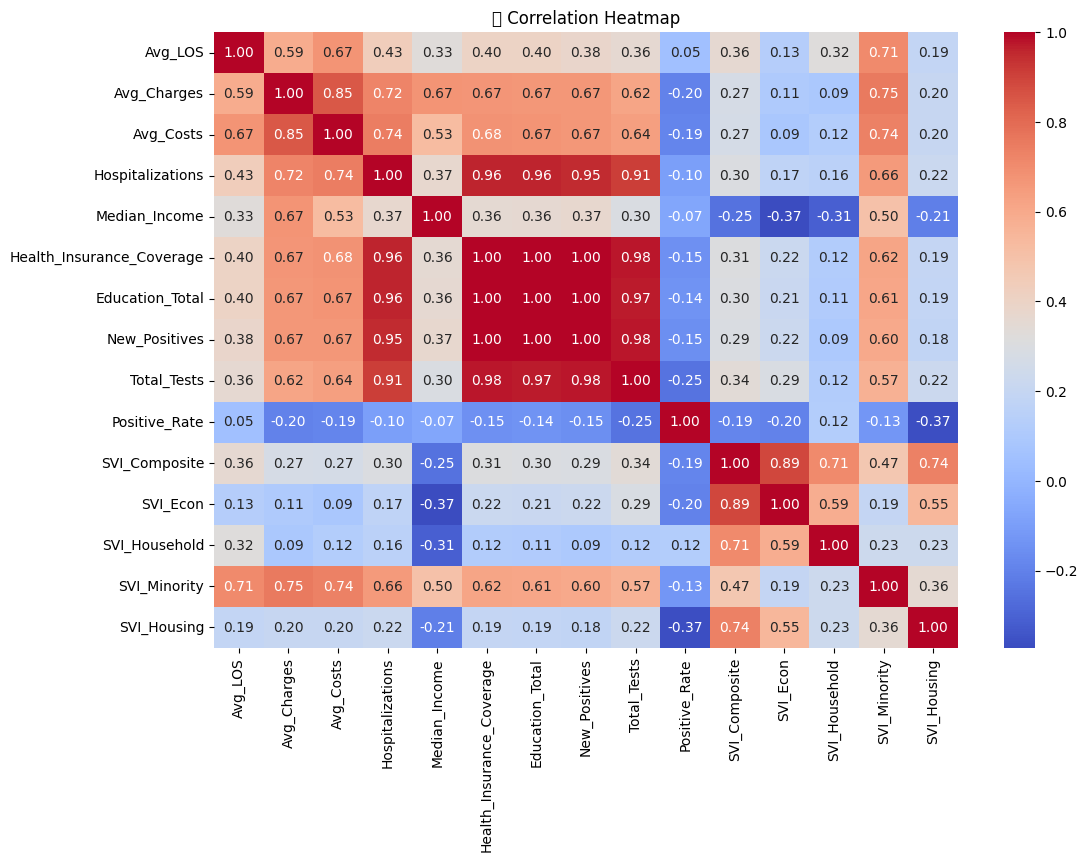

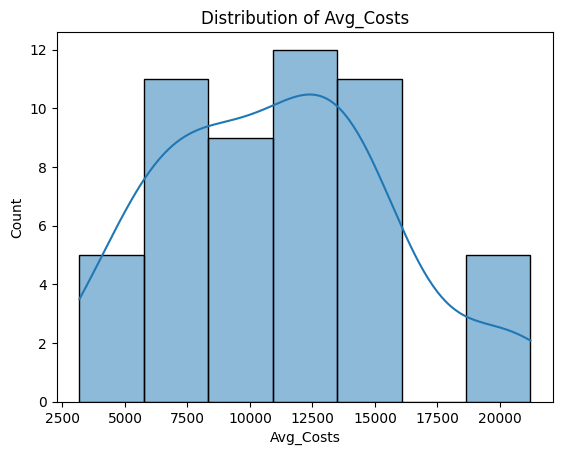

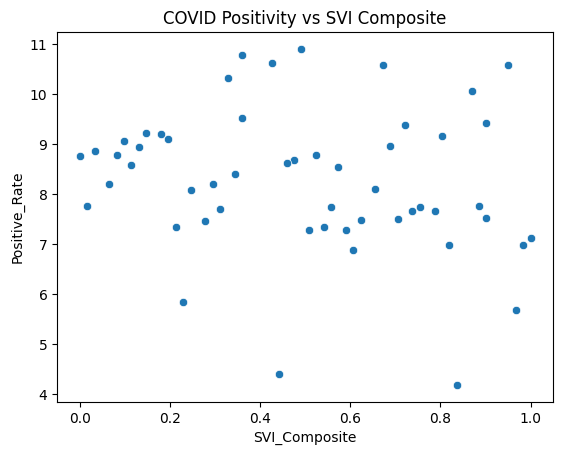

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(final_df.corr(numeric_only=True), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("🔍 Correlation Heatmap")
plt.show()

# Distribution of Avg_Costs
sns.histplot(final_df['Avg_Costs'], kde=True)
plt.title("Distribution of Avg_Costs")
plt.show()

# SVI vs COVID
sns.scatterplot(x='SVI_Composite', y='Positive_Rate', data=final_df)
plt.title("COVID Positivity vs SVI Composite")
plt.show()


In [41]:
# Replace these paths with the actual path in your Drive
fatalities_path = '/content/drive/MyDrive/Colab Notebooks/New_York_State_Statewide_COVID-19_Fatalities_by_County_20250407.csv'
hospitalizations_path = '/content/drive/MyDrive/Colab Notebooks/New_York_State_Statewide_COVID-19_Hospitalizations_and_Beds_20250407.csv'

fatalities_df = pd.read_csv(fatalities_path)
hospitalizations_df = pd.read_csv(hospitalizations_path)

# Aggregate total deaths by County
fatalities_summary = (
    fatalities_df.groupby('County', as_index=False)
    .agg({'Deaths by County of Residence': 'sum'})
    .rename(columns={'Deaths by County of Residence': 'Total_COVID_Deaths'})
)


# Aggregate hospitalization metrics by Facility County
hospitalization_summary = (
    hospitalizations_df.groupby('Facility County', as_index=False)
    .agg({
        'Patients Currently Hospitalized': 'sum',
        'Patients Currently in ICU': 'sum',
        'Total Staffed Beds': 'sum'
    })
    .rename(columns={'Facility County': 'County', 'Patients Currently in ICU': 'Patients in ICU till APR25'})
)


# Ensure consistent formatting across datasets
final_df['County'] = final_df['County'].str.strip().str.title()
fatalities_summary['County'] = fatalities_summary['County'].str.strip().str.title()
hospitalization_summary['County'] = hospitalization_summary['County'].str.strip().str.title()


merged_df = final_df.merge(fatalities_summary, on='County', how='left')
merged_df = merged_df.merge(hospitalization_summary, on='County', how='left')
merged_df.to_csv('/content/drive/MyDrive/Colab Notebooks/enriched_county_level_dataset.csv', index=False)

# Or preview
merged_df.head()

,County,Avg_LOS,Avg_Charges,Avg_Costs,Hospitalizations,Median_Income,Health_Insurance_Coverage,Education_Total,New_Positives,Total_Tests,Positive_Rate,SVI_Composite,SVI_Econ,SVI_Household,SVI_Minority,SVI_Housing,Total_COVID_Deaths,Patients Currently Hospitalized,Patients in ICU till APR25,Total Staffed Beds
0,Albany,5.159561,46882.616018,14075.244396,22496,73810,310934,211245,50265,578622,8.687018,0.4754,0.1639,0.2951,0.7869,0.8361,436791,83952,14952,515106
1,Allegany,3.588235,13144.786983,5128.391357,663,54375,46170,30019,6538,74503,8.775486,0.5246,0.6885,0.3443,0.0328,0.6721,114532,4842,763,28496
2,Bronx,5.660587,67473.762745,21217.886357,58511,43726,1447001,959432,322042,4517404,7.128917,1.0000,1.0000,0.9672,1.0000,0.9508,5163866,277572,56196,1476804
3,Broome,5.392927,29213.989886,12464.602497,7693,53982,195882,131719,36482,484969,7.522543,0.9016,0.8033,0.8525,0.6066,0.9180,428473,56309,7515,297075
4,Cattaraugus,4.377824,13875.673430,5883.270898,1904,53537,76414,53033,12170,120998,10.058017,0.8689,0.8033,0.9180,0.3770,0.6393,153679,14047,2104,67472
